In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import seaborn as sn
from IPython.display import clear_output
import datetime

#For models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from statsmodels.discrete.discrete_model import Probit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

from sklearn.metrics import precision_recall_curve

    
def pc(x,X, dec=1):
    return str(round(100*(x/X),dec))+"%"

NJOBS=6

# VI - 0- Preparing train and test dataset

In [2]:
!/usr/bin/env ls output_data/working_data/ | grep DFA
DFA_chosen = input('Choose a DFA in the list above')

DFA.p
DFA_1to50-0.9%.p
DFA_1to50-1.0%.p
DFA_30to50-1.3%.p
DFA_30to50.p
DFA_8to201.2%.p
DFA_8to201.3%.p
DFA_cnt_superior_to_50.p
DFA_greater_than_50-0.1%.p
DFA_greater_than_50-1.3%.p
DFA_no_condition-0.9%.p
DFAsmall1.p
Choose a DFA in the list aboveDFA_no_condition-0.9%.p


In [12]:
with open('output_data/working_data/{}'.format(DFA_chosen), 'rb') as f :
    DFA = pickle.load(f)
    #Get rid of base links and shuffle it
    DFA = DFA[DFA['BASE']==0].sample(frac=1).drop(['BASE'],axis=1)
    
print("■ YOU IMPORTED //{}// SUCCESSFULLY".format(DFA_chosen))
Ntargets = DFA['TARGET'].sum()
Ncandidates = DFA.shape[0]
print(Ntargets, Ncandidates, "--", pc(Ntargets,Ncandidates), "of target links ")

■ YOU IMPORTED //DFA_no_condition-0.9%.p// SUCCESSFULLY
12436 1405662 -- 0.9% of target links 


In [13]:
wanted_pc = 2 * 0.01
after_sampling = 30000

TL = DFA[DFA['TARGET']==1]
FL = DFA[DFA['TARGET'] == 0]

fake_links_wanted = int((1-wanted_pc)*TL.shape[0]/wanted_pc)
DFA_ = pd.concat([TL,FL.sample(fake_links_wanted)],ignore_index=True)
if after_sampling > 0 :
    DFA_ = DFA_.sample(after_sampling)
    
DFA, DFA_ = DFA_, DFA

In [14]:
print("■ YOU RESIZED //{}// SUCCESSFULLY".format(DFA_chosen))
Ntargets = DFA['TARGET'].sum()
Ncandidates = DFA.shape[0]
print(Ntargets, Ncandidates, "--", pc(Ntargets,Ncandidates), "of target links ")

■ YOU RESIZED //DFA_no_condition-0.9%.p// SUCCESSFULLY
614 30000 -- 2.0% of target links 


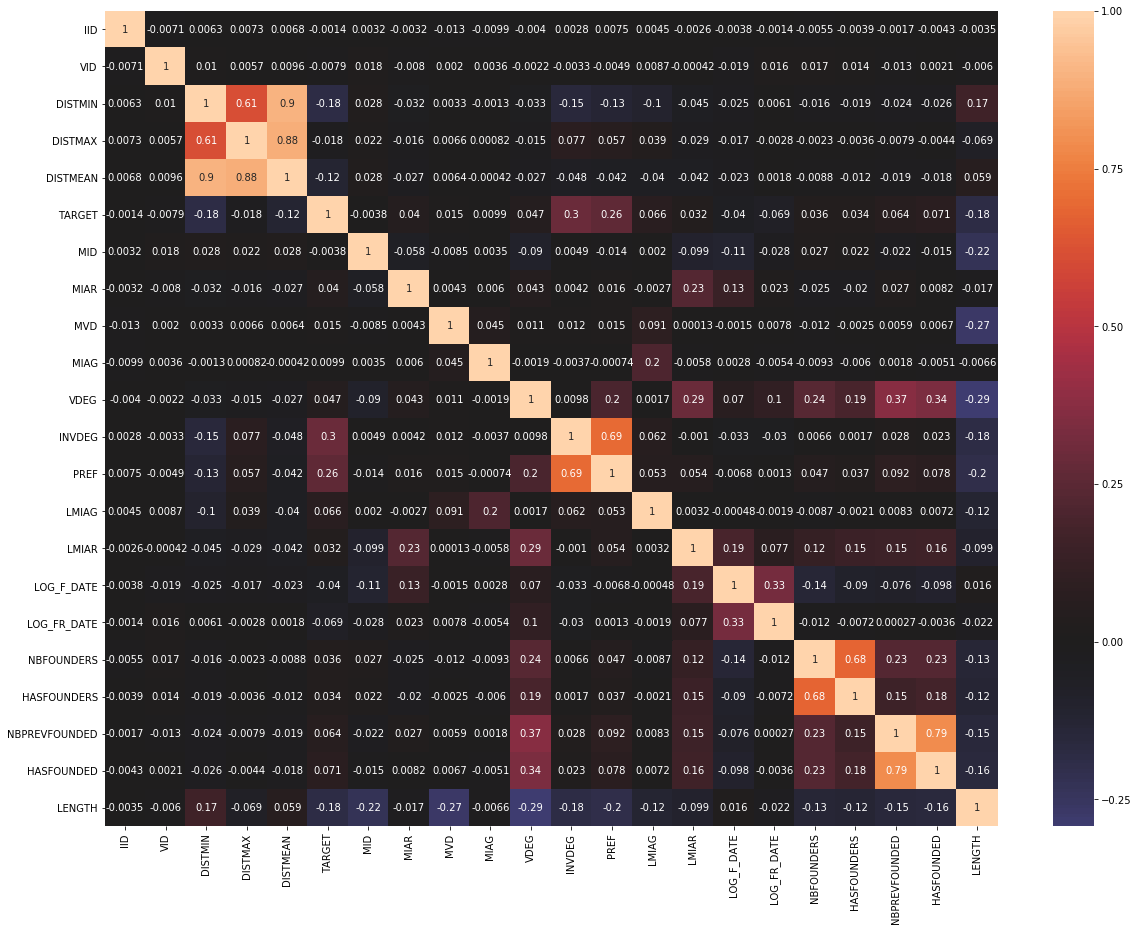

In [15]:
plt.figure(figsize=(20,15))
sn.heatmap(DFA.corr(), annot=True, center=0)

## SHAP IMPORTANCE OF FEATURES

### III - B : Further analysis for RandomForestClassifier possibilities

In [16]:
Ycolumns = ['MID', 'MIAR', 'MVD', 'MIAG', 'VDEG', 'INVDEG', 'PREF', 'LMIAG', 'LMIAR',
            'LOG_F_DATE', 'LOG_FR_DATE', 'NBFOUNDERS', 'HASFOUNDERS', 'NBPREVFOUNDED', 'HASFOUNDED']
Zcolumns = Ycolumns + ['LENGTH'] + ['DISTMIN', 'DISTMAX', 'DISTMEAN']

In [17]:
%%time
import shap
from sklearn.ensemble import RandomForestRegressor
# load JS visualization code to notebook
shap.initjs()


DFTRAIN = DFA
Xtrain = DFTRAIN[Zcolumns]
Ytrain = DFTRAIN['TARGET']
# train XGBoost model
X,y = Xtrain, Ytrain
model = RandomForestRegressor(n_estimators=500, max_depth=50, n_jobs=6).fit(X,y)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)


CPU times: user 46min 2s, sys: 1.25 s, total: 46min 4s
Wall time: 44min 8s


In [18]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1705,:], X.iloc[1705,:])

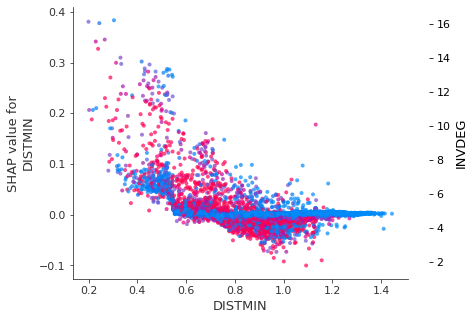

In [19]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
plt.figure(figsize=(20,20))
shap.dependence_plot("DISTMIN", shap_values, X, x_jitter=0.6, alpha=0.7)
plt.show()

■ name of file :  2019-6-4-12h48-2.0pc-[DFA_no_condition-0.9%.p].png


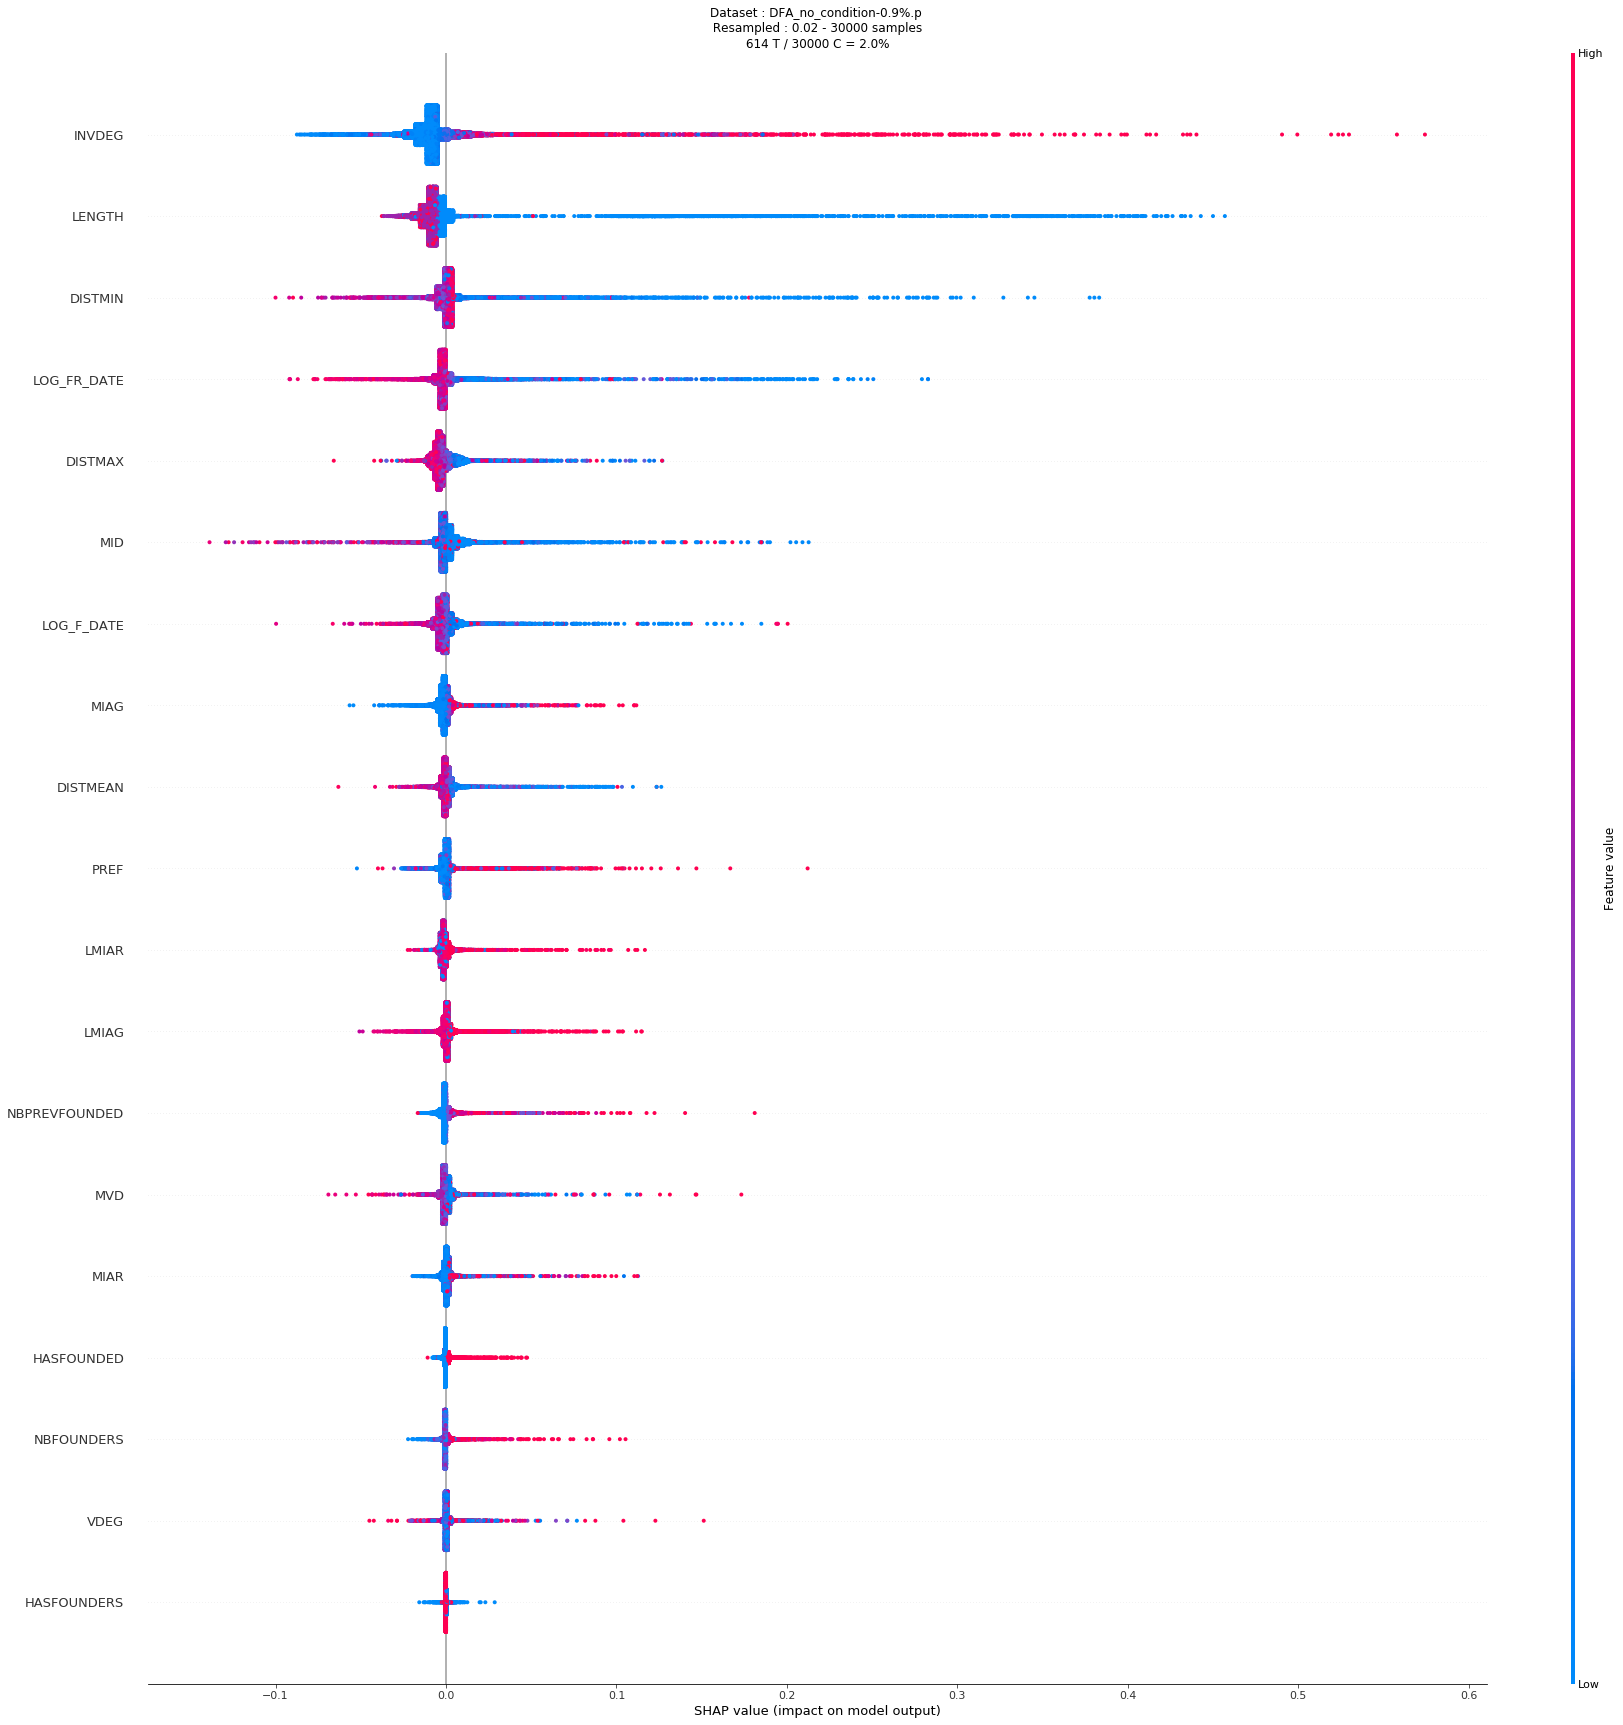

In [20]:
# summarize the effects of all the features
plt.figure(figsize=(30,30))
plt.title("Dataset : {} \n Resampled : {} - {} samples \n {} T / {} C = {} ".format(DFA_chosen, wanted_pc, after_sampling, Ntargets, Ncandidates,  pc(Ntargets,Ncandidates)))
shap.summary_plot(shap_values, Xtrain, auto_size_plot=False, show=False)

now = datetime.datetime.now()
name = "{0}-{1}-{2}-{3}h{4}".format(now.year, now.month, now.day, now.hour, now.minute)
name += "-" + str(round(100*DFTRAIN['TARGET'].sum()/DFTRAIN.shape[0],1)) + "pc-"
name += "[{}]".format(DFA_chosen)
name+= ".png"
print("■ name of file : " , name)
plt.savefig("./output_data/SHAP" + name )
plt.show()

■ name of file :  2019-6-4-12h48-2.0pc-[DFA_no_condition-0.9%.p].png


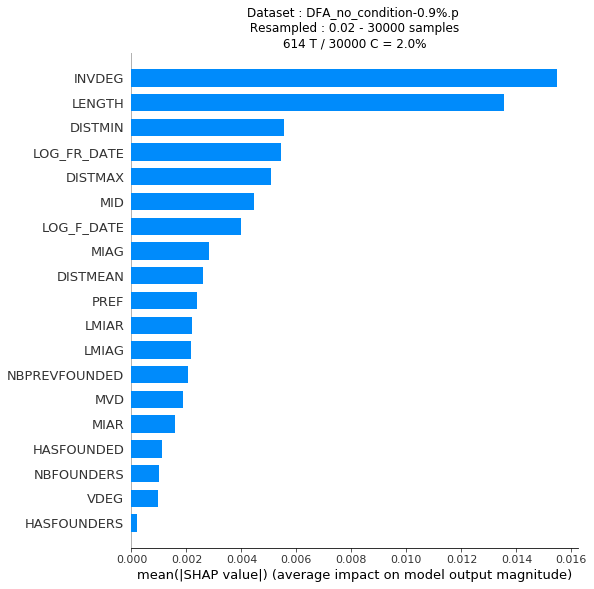

In [21]:
# summarize the effects of all the features
plt.figure(figsize=(30,30))
plt.title("Dataset : {} \n Resampled : {} - {} samples \n {} T / {} C = {} ".format(DFA_chosen, wanted_pc, after_sampling, Ntargets, Ncandidates,  pc(Ntargets,Ncandidates)))

shap.summary_plot(shap_values, X, plot_type="bar", show=False)

now = datetime.datetime.now()
name = "{0}-{1}-{2}-{3}h{4}".format(now.year, now.month, now.day, now.hour, now.minute)
name += "-" + str(round(100*DFTRAIN['TARGET'].sum()/DFTRAIN.shape[0],1)) + "pc-"
name += "[{}]".format(DFA_chosen)
name+= ".png"
print("■ name of file : " , name)
plt.savefig("./output_data/SHAP2" + name )
plt.show()